In [1]:
from IPython.display import Image

In [2]:
import torchvision

In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/data/list_attr_celeba.txt')
col_names = list(df.iloc[0])

splited_data =df.iloc[1:,0].str.split()


In [4]:

print(len(col_names[0].split()))
col_names[0].split()[:5]

40


['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald']

In [5]:
# splited_data.values.tolist()
new_df = pd.DataFrame(splited_data.values.tolist())

In [6]:
new_df.columns = ['filename'] + col_names[0].split()

In [7]:
Smiling_df = new_df.loc[:,('filename','Smiling')]
Smiling_df.head(5)

,filename,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,-1
3,000004.jpg,-1
4,000005.jpg,-1


In [8]:
smile_jpg_20 = Smiling_df[Smiling_df['Smiling'] == '1']['filename'].values[:20]
smile_jpg_20

array(['000001.jpg', '000002.jpg', '000009.jpg', '000011.jpg',
       '000012.jpg', '000013.jpg', '000014.jpg', '000016.jpg',
       '000017.jpg', '000018.jpg', '000021.jpg', '000023.jpg',
       '000027.jpg', '000028.jpg', '000029.jpg', '000031.jpg',
       '000033.jpg', '000038.jpg', '000039.jpg', '000041.jpg'],
      dtype=object)

구글 드라이브에서 이미지 가져와서 압축풀기

In [ ]:
!unzip /content/drive/MyDrive/data/img_align_celeba.zip -d celeba

In [143]:
from glob import glob
glob('/content/celeba/img_align_celeba/*')[:2]

['/content/celeba/img_align_celeba/100740.jpg',
 '/content/celeba/img_align_celeba/012281.jpg']

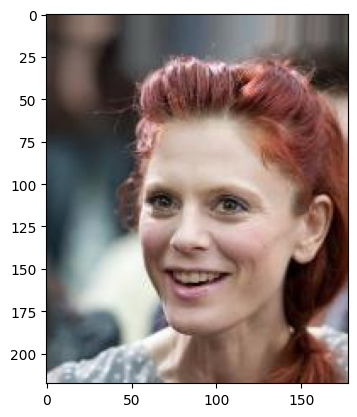

In [11]:
import matplotlib.pyplot as plt

from PIL import Image
image_path = '/content/celeba/img_align_celeba/' + '000002.jpg'
image = Image.open(image_path)
plt.imshow(image)

<Figure size 1200x800 with 0 Axes>

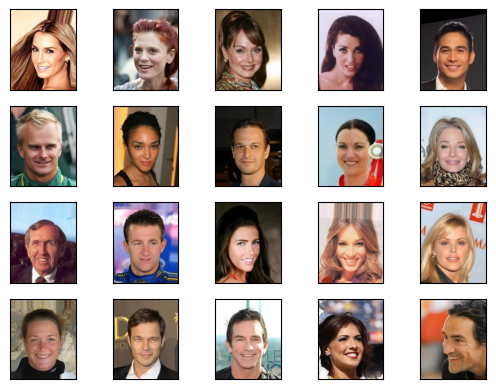

In [12]:
import matplotlib.pyplot as plt

from PIL import Image
image_path = '/content/celeba/img_align_celeba/'
plt.figure(figsize=(12,8))
fig, axs = plt.subplots(4, 5)
# plt.subplots_adjust(wspace=0.1, hspace=0.0001)
for idx,file in enumerate(smile_jpg_20):
  image = Image.open(image_path+file)
  axs[idx // 5,idx % 5].imshow(image)
  axs[idx // 5,idx % 5].set_xticks([])
  axs[idx // 5,idx % 5].set_yticks([])
plt.show()

데이터셋 데이터로더

In [29]:
Smiling_df['Smiling'] = Smiling_df['Smiling'].str.replace('-1','0').astype(int)

In [30]:
from torch.utils.data import Dataset

In [31]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

class CustomDataset(Dataset):
  def __init__(self,dataframe, root_dir, transform=None):
    super().__init__()
    self.dataframe = dataframe
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self,idx):
    img_name = os.path.join(self.root_dir,self.dataframe.iloc[idx,0])
    image = Image.open(img_name)
    label = int(self.dataframe.iloc[idx,1])
    if self.transform:
      image = self.transform(image)
    return image, label

In [116]:
transform = transforms.Compose([
    transforms.RandomCrop([178,178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])
params = {
    'dataframe' : Smiling_df,
    'root_dir' : '/content/celeba/img_align_celeba',
    'transform' : transform
}
dataset = CustomDataset(**params)

In [155]:
from torch.utils.data import Subset
#  크기를 줄이기
import random
# len(dataset) 202599
indices = random.sample(range(len(dataset)), len(dataset)//20 )

dataset = Subset(dataset, indices)

In [156]:
202599 // 20

10129

In [157]:
# 데이터셋 확인
dataset[0][0].shape


torch.Size([3, 64, 64])

In [158]:
from torch.utils.data import DataLoader

In [159]:
import torch
torch.manual_seed(1)
data_loader =  DataLoader(dataset,batch_size = 2)

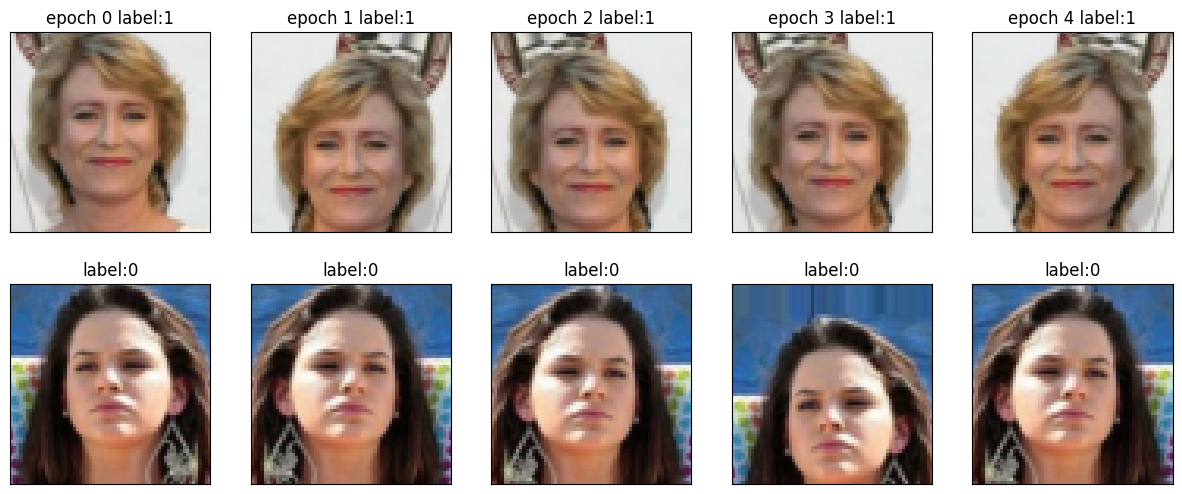

In [160]:
# img_batch, label_batch =  next(iter(data_loader))
def confirmDataLoader(data_loader):
  fig = plt.figure(figsize=(15,6))
  num_epochs = 5
  for j in range(num_epochs):
    img_batch, label_batch =  next(iter(data_loader))
    img =img_batch[0]
    ax = fig.add_subplot(2,5,j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"epoch {j} label:{label_batch[0]}")
    ax.imshow(img.permute(1,2,0))

    img =img_batch[1]
    ax = fig.add_subplot(2,5,j+6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"label:{label_batch[1]}")
    ax.imshow(img.permute(1,2,0))
  plt.show()

confirmDataLoader(data_loader)

In [161]:
len(dataset)

10129

In [162]:
from torch.utils.data import random_split

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_size = int(train_ratio* len(dataset))
val_size = int(val_ratio* len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [163]:
len(test_dataset)

2027

In [164]:
batch_size = 32
train_dl = DataLoader(train_dataset,batch_size,shuffle=True)
valid_dl = DataLoader(val_dataset,batch_size,shuffle=True)
test_dl = DataLoader(test_dataset,batch_size,shuffle=True)

데이터로드에 있는 데이터를 확인

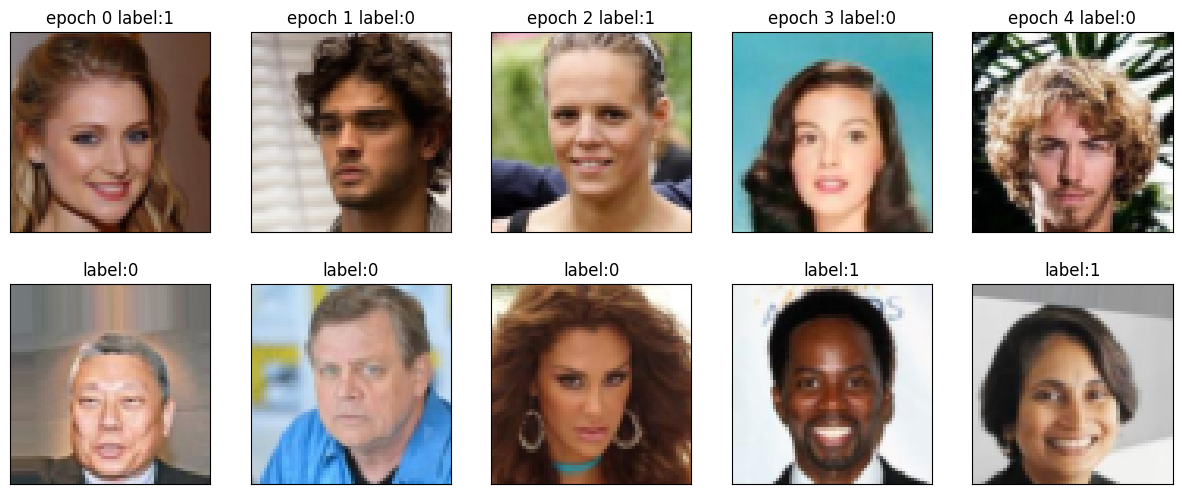

In [165]:
# a,b =  next(iter(train_dl))
confirmDataLoader(valid_dl)

CNN 웃는 얼굴 분류기 훈련

In [166]:
import torch.nn as nn
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1))
model.add_module('relu4', nn.ReLU())

In [167]:
# 모델과 입력데이터 테스트
x = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [168]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))

In [169]:
# 모델과 입력데이터 테스트
x = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 256, 1, 1])

In [170]:
model.add_module('flatten', nn.Flatten())

In [171]:
# 모델과 입력데이터 테스트
x = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 256])

In [172]:
model.add_module('fc', nn.Linear(256,1))
model.add_module('sigmoid',nn.Sigmoid())

In [173]:
# 모델과 입력데이터 테스트
x = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 1])

In [174]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [175]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [179]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      pred = model(x_batch)[:,0]
      loss = loss_fn(pred, y_batch.float())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item() * y_batch.size(0)
      is_correct = ( (pred >=0.5).float() == y_batch  ).float()
      accuracy_hist_train[epoch] += is_correct.sum().cpu()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()  # 평가
    with torch.no_grad(): # 기울기 적용안함
      for x_batch, y_batch in valid_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:,0]
        loss = loss_fn(pred, y_batch.float())
        loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
        is_correct = ( (pred >=0.5).float() == y_batch  ).float()
        accuracy_hist_valid[epoch] += is_correct.sum().cpu()
    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f"에포크{epoch} 정확도{accuracy_hist_train[epoch]:.4f}\
          검증정확도:{accuracy_hist_valid[epoch]:.4f}")
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [180]:
torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl,valid_dl)

에포크0 정확도0.5355          검증정확도:0.5254
에포크1 정확도0.5356          검증정확도:0.5160
에포크2 정확도0.5531          검증정확도:0.5511
에포크3 정확도0.5601          검증정확도:0.5748
에포크4 정확도0.6047          검증정확도:0.6444
에포크5 정확도0.6194          검증정확도:0.6558
에포크6 정확도0.6316          검증정확도:0.6598
에포크7 정확도0.6472          검증정확도:0.6489
에포크8 정확도0.6553          검증정확도:0.6746
에포크9 정확도0.6618          검증정확도:0.6677
에포크10 정확도0.6636          검증정확도:0.6830
에포크11 정확도0.6709          검증정확도:0.6800
에포크12 정확도0.6806          검증정확도:0.6968
에포크13 정확도0.6763          검증정확도:0.6736
에포크14 정확도0.6854          검증정확도:0.6909
에포크15 정확도0.6880          검증정확도:0.6844
에포크16 정확도0.6920          검증정확도:0.7012
에포크17 정확도0.6957          검증정확도:0.6696
에포크18 정확도0.7076          검증정확도:0.7091
에포크19 정확도0.7183          검증정확도:0.7086
에포크20 정확도0.7206          검증정확도:0.7551
에포크21 정확도0.7410          검증정확도:0.7689
에포크22 정확도0.7468          검증정확도:0.7452
에포크23 정확도0.7639          검증정확도:0.7921
에포크24 정확도0.7721          검증정확도:0.8252
에포크25 정확도0.7830          검증정확도:0.8104
에포크26 정확도0.7986       

In [182]:
path = '/content/drive/MyDrive/data/smile.pth'
torch.save(model,path)

In [183]:
loaded_model = torch.load(path)

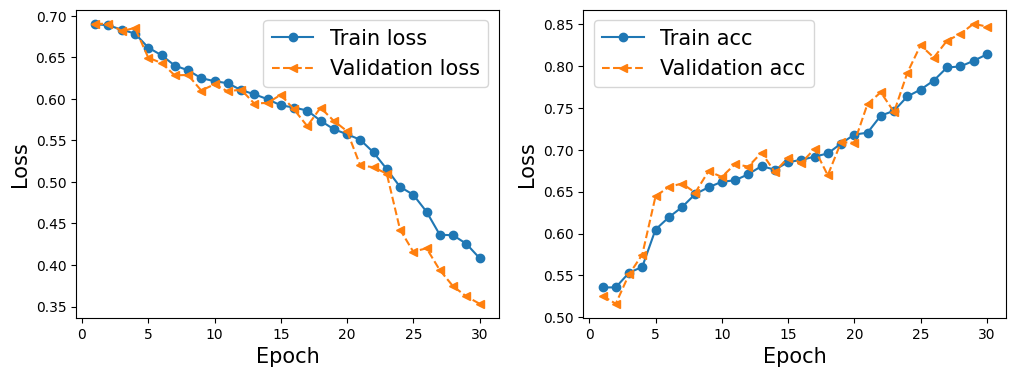

In [186]:
# 시각화
x_arr =  np.arange(len(hist[0])) + 1
fig = plt.figure(figsize = (12,4) )
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], '-o', label="Train loss")
ax.plot(x_arr, hist[1], '--<', label="Validation loss")
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist[2], '-o', label="Train acc")
ax.plot(x_arr, hist[3], '--<', label="Validation acc")
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

plt.show()

In [188]:
# 정확도
accuracy_test = 0
loaded_model.eval()
with torch.no_grad():
  for x_batch, y_batch in test_dl:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    pred = model(x_batch)[:,0]
    is_correct =( (pred >= 0.5).float() == y_batch ).float()
    accuracy_test += is_correct.sum().cpu()
accuracy_test /= len(test_dl.dataset)
print(f"테스트 정확도 : {accuracy_test:.4f}")

테스트 정확도 : 0.8550


In [192]:
loaded_model(x_batch)[:,0]

tensor([0.2884, 0.2713, 0.9057, 0.9758, 0.9119, 0.9832, 0.8910, 0.2470, 0.6759,
        0.2682, 0.8758], grad_fn=<SelectBackward0>)

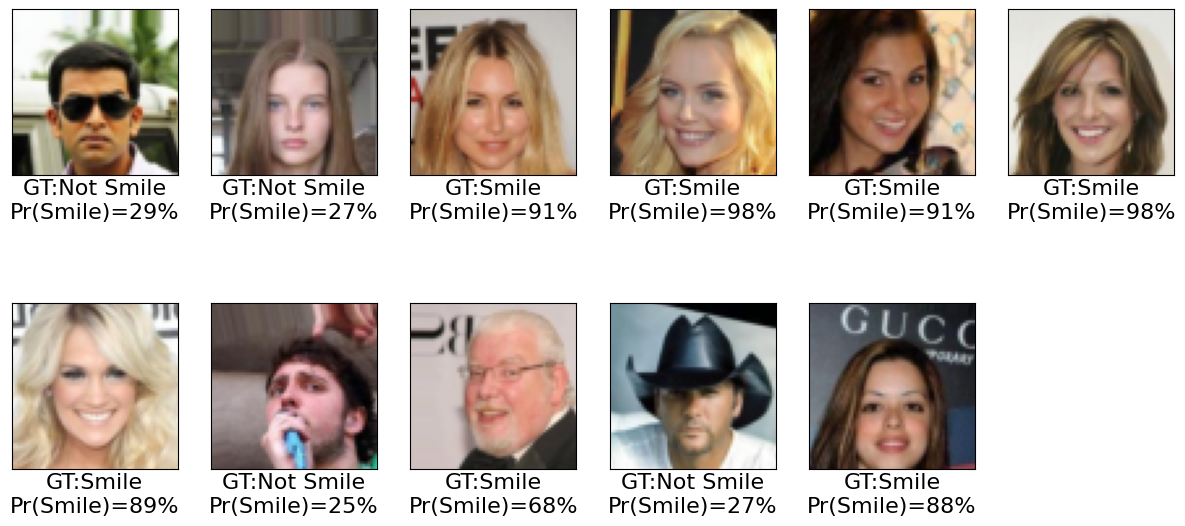

In [202]:
pred = loaded_model(x_batch)[:,0] * 100  # % 로 변경하기위해서
fig = plt.figure(figsize=(15,7))
x_batch.shape[0] # 11
for j in range(x_batch.shape[0]):
  ax = fig.add_subplot(2,6,j+1)
  ax.set_xticks([]),ax.set_yticks([])
  # (3,64,64) -- >(64,64,3)
  ax.imshow(x_batch[j].cpu().permute(1,2,0) )
  if y_batch[j] == 1:
    label = 'Smile'
  else:
    label = 'Not Smile'
  ax.text(
      0.5,-0.15,
      f'GT:{label:s}\nPr(Smile)={pred[j]:.0f}%',
      size=16,
      horizontalalignment='center',
      verticalalignment = 'center',
      transform=ax.transAxes
  )
plt.show()

In [200]:
x_batch.shape[0]

11

In [203]:
# 테스트용 사진을 가지고 실제 웃는지 판단

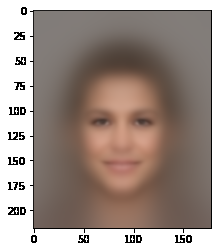

In [213]:
example_path = '/content/drive/MyDrive/data/example-image.png'
from PIL import Image
Image.open(example_path)

In [211]:
x_batch.shape

torch.Size([11, 3, 64, 64])

In [219]:
# 데이터는 (1,3,64,64)
sample_img = Image.open(example_path)
tr_sample_img = transform(sample_img)
tr_sample_img = tr_sample_img.unsqueeze(0)
tr_sample_img.shape

torch.Size([1, 3, 64, 64])

In [226]:
if loaded_model(tr_sample_img).cpu()[0][0] > 0.5:
  print('Smile')
else:
  print('Not Smile')

Not Smile
